In [36]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import numpy as np


import json
import pandas as pd
import pickle
# Load environment variables
from dotenv import load_dotenv
load_dotenv()
DATA_PATH = os.getenv("DATA_PATH")
SAVE_PATH = os.getenv("RESULTS_PATH")
FULL_PAGE_WIDTH_CM = float(os.getenv("FULL_PAGE_WIDTH_CM"))
FULL_PAGE_LENGTH_CM = float(os.getenv("FULL_PAGE_LENGTH_CM"))

from src.plotting_utilities import cm_to_inches,setup_plotting,set_spines_width,ZeroIncludingMaxNLocator

label_dict,tick_dict, title_dict, legend_dict = setup_plotting()


In [37]:
# 1. Load merged datasets per counter
with open(f'{DATA_PATH}/merged_datasets_per_counter.pkl', 'rb') as f:
    merged_datasets_complete = pickle.load(f)

# 2. Load bike counter dataframe

with open(f"{DATA_PATH}/bike_counters/_bike_counters_IDs.json", "r") as f:
    bike_counters_ids = json.load(f)

## Figure: Normalised Timeseries

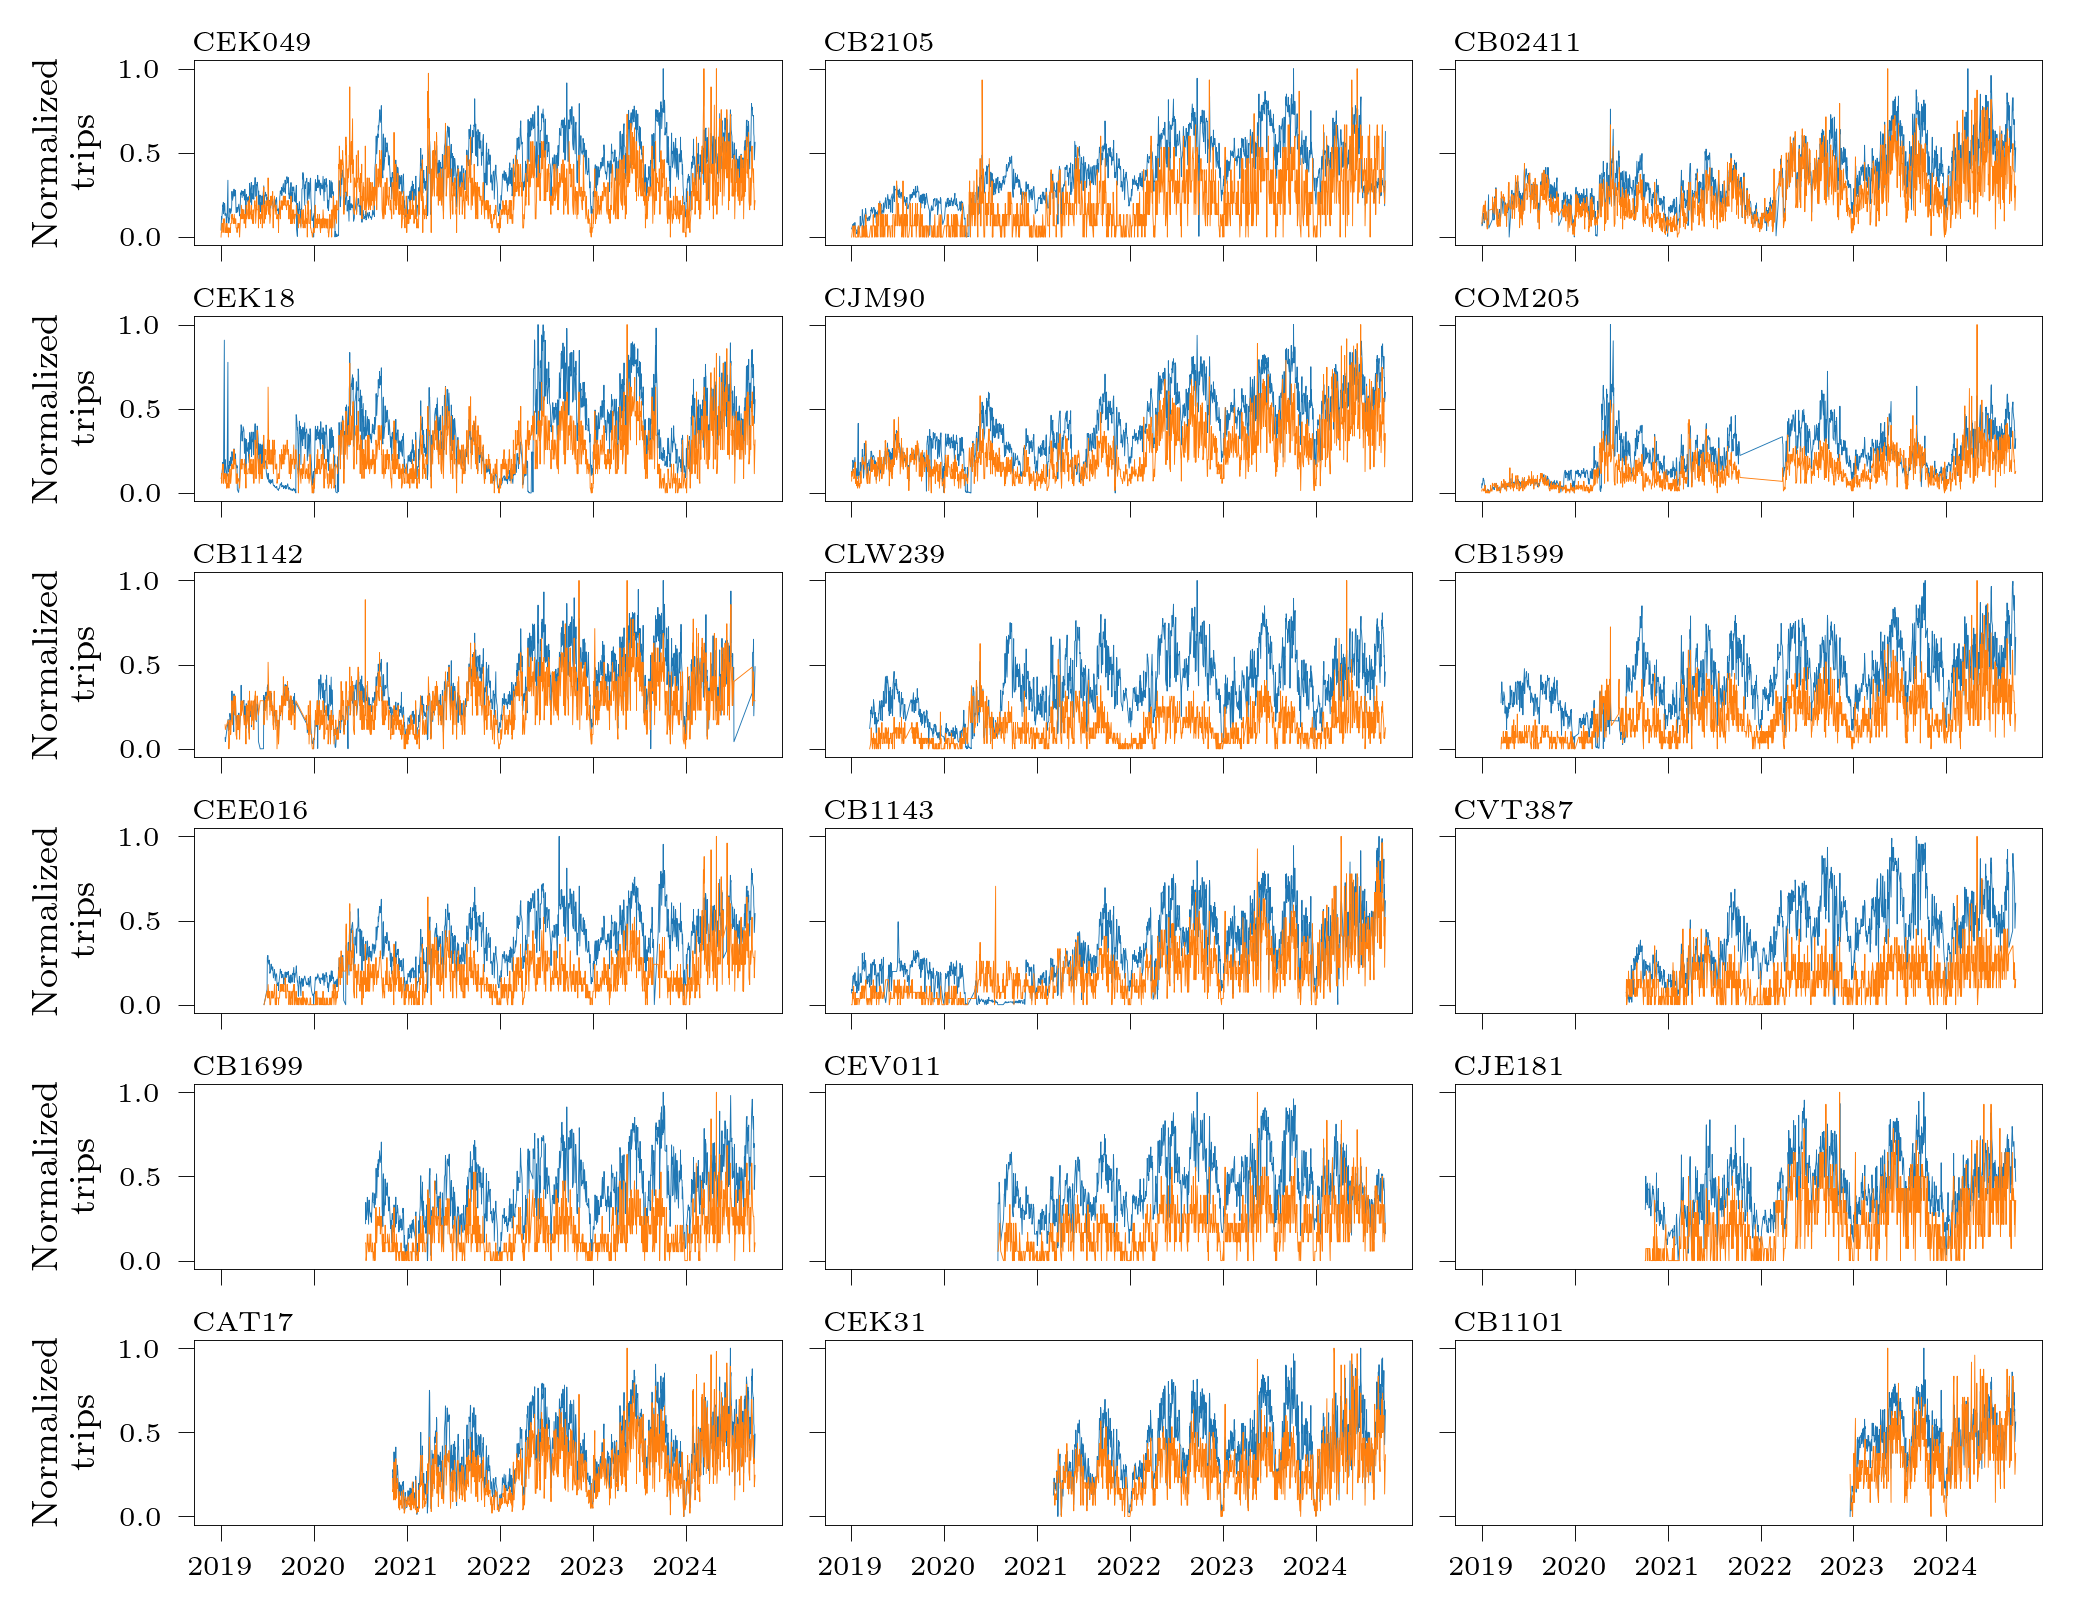

In [38]:
nr_of_colums = 3
nr_of_rows = math.ceil(len(bike_counters_ids)/nr_of_colums)

fig_timeseries,ax_timeseries = plt.subplots(nr_of_rows,nr_of_colums,figsize = (cm_to_inches(FULL_PAGE_WIDTH_CM),cm_to_inches(FULL_PAGE_LENGTH_CM)/2),dpi = 325,
                            gridspec_kw = {'width_ratios': nr_of_colums*[1] ,'height_ratios': nr_of_rows*[1],'hspace':0.01},sharey=True,sharex=True,constrained_layout = True)


for idx,device_name in enumerate(bike_counters_ids):
    ax = ax_timeseries[math.floor(idx/nr_of_colums),idx%nr_of_colums]
    device_combined = merged_datasets_complete[device_name]
    device_combined['date_timestamp'] = device_combined['date'].astype('int64') // 10**9
    # We plot the data
    device_combined.plot(x = 'date_timestamp',y = ['counter_trips_normalised','strava_trips_normalised'],ax =ax,linewidth = 0.2)

    ax.get_legend().remove() 
    ax.tick_params(axis='both',which='both',labelsize=tick_dict['fontsize'],width =0.2)
    ax.tick_params(axis='x',which='minor',length=0)
    ax.set_xlabel('')
    #ax.set_xlim([pd.Timestamp('2019-01-01'), pd.Timestamp('2024-09-30')])
    ax.set_xticks([pd.Timestamp(f'{year}-01-01').timestamp() for year in range(2019,2025)])
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: pd.to_datetime(x, unit='s').strftime('%Y')))
    if idx%nr_of_colums == 0:
        ax.set_ylabel('Normalized\n trips',fontsize = label_dict['fontsize'])
    ax.text(0, 1.15,
                        horizontalalignment='left',
                        verticalalignment='top',
                        transform=ax.transAxes,s = device_name,fontsize = 6)
    
    set_spines_width(ax,width = 0.2)

fig_timeseries.savefig(f"{SAVE_PATH}/figures/normalised_timeseries_per_counter.pdf",dpi = 325)

 ## Figure: Scatter plot

CEK18 2019 -0.056174568639405634
CB1143 2020 -0.28521996214993806
CB1101 2022 -0.511444162615053


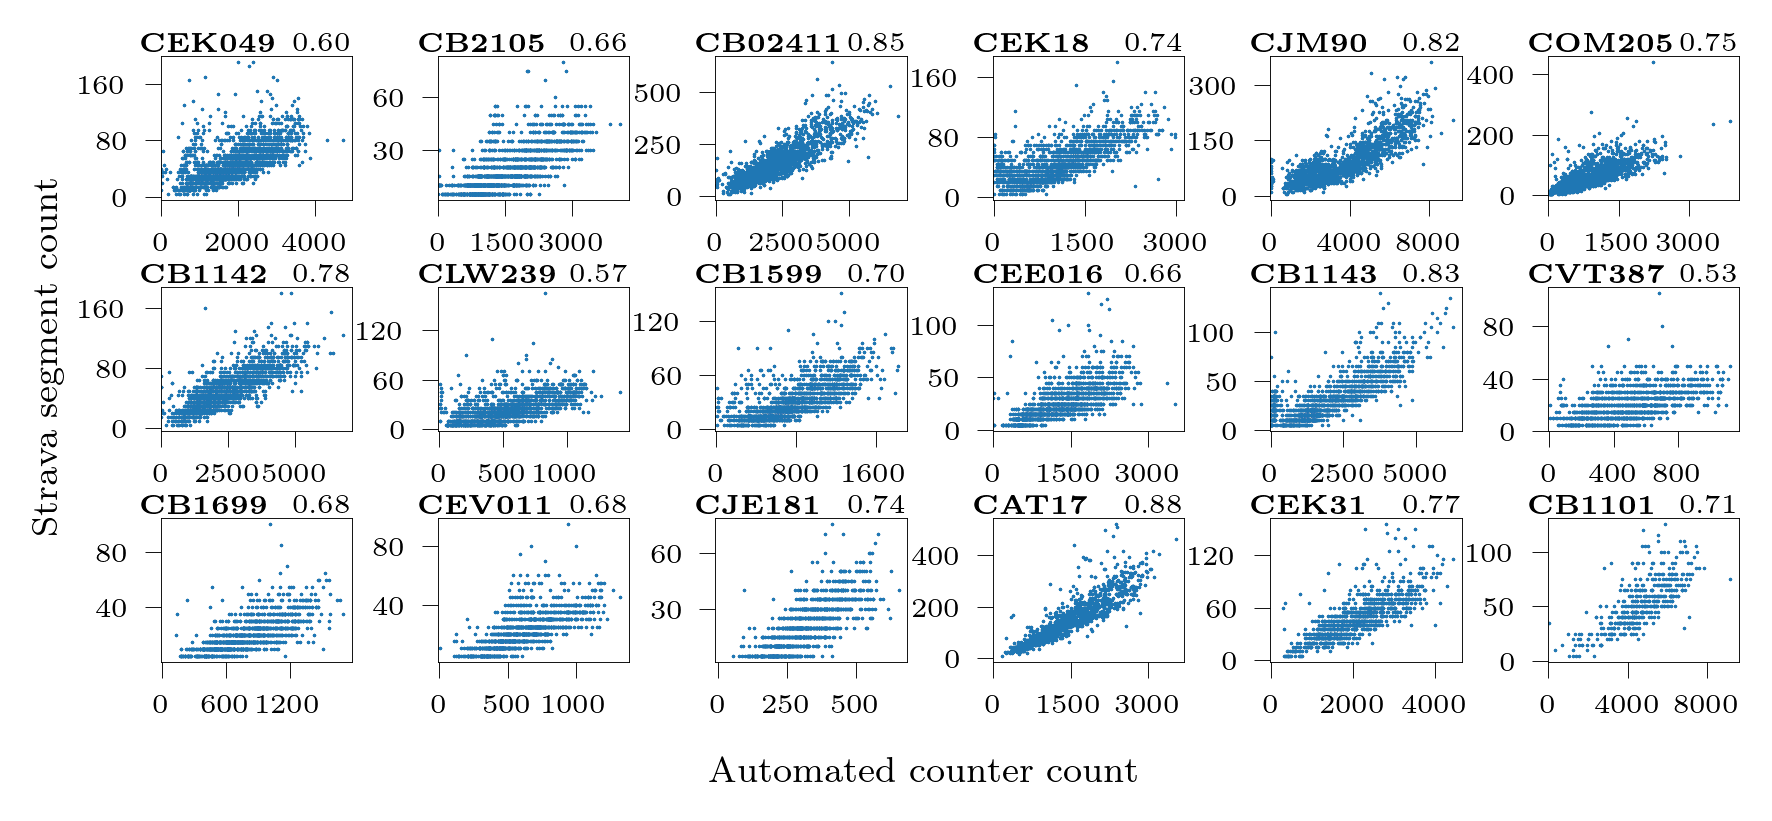

In [39]:
nr_of_colums = 6
nr_of_rows = 3
fig_scatter,ax_scatter = plt.subplots(nr_of_rows,nr_of_colums,figsize = (cm_to_inches(FULL_PAGE_WIDTH_CM),cm_to_inches(FULL_PAGE_LENGTH_CM)/4),dpi = 325,
                            gridspec_kw = {'height_ratios': nr_of_rows*[1] ,'width_ratios': nr_of_colums*[1], 'hspace': 0.6,'wspace':0.45})#,sharey = True,sharex = True)


for idx,device_name in enumerate(bike_counters_ids):
    device_combined = merged_datasets_complete[device_name]
    ax = ax_scatter[math.floor(idx/nr_of_colums),idx%nr_of_colums]

    years_to_exclude = []
    for year in [2019,2020,2021,2022,2023,2024]:
        device_combined_year = device_combined.loc[device_combined['year'] == year]

        corr_year = device_combined_year['counter_trips'].corr(device_combined_year['strava_trips'])
        if corr_year <=0:
            print(f"{device_name} {year} {corr_year}")
            years_to_exclude.append(year)
        else:
            scatterplot = device_combined.plot(x = 'counter_trips',y = 'strava_trips',s = 0.05,kind = 'scatter',ax =ax,alpha = 0.6,linewidth = 0.5) 
        

    device_combined = device_combined.loc[~device_combined['year'].isin(years_to_exclude)]
    corr = device_combined['counter_trips'].corr(device_combined['strava_trips'])

    ax.text(1, 1.,
            ha = 'right',
            va = 'bottom',
            s= f"{corr:.2f}", 
            transform=ax.transAxes, fontsize=6)
    
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_xlim(left=-10)
    ticker_class_x =ZeroIncludingMaxNLocator(3)
    ticker_class_y =ZeroIncludingMaxNLocator(3)
    ax.xaxis.set_major_locator(ticker_class_x)
    ax.yaxis.set_major_locator(ticker_class_y)

    ax.text(-0.1, 1.16,
                        horizontalalignment='left',
                        verticalalignment='top',
                        transform=ax.transAxes,s = r"$\mathbf{"+device_name+"}$",fontsize = 6)


    set_spines_width(ax,width = 0.2)
    ax.tick_params(axis='both',labelsize=tick_dict['fontsize'],width =0.2)

_ = ax_scatter[1,5].text(0.5, -0.03, 'Automated counter count', ha='center', va='center',fontsize = label_dict['fontsize'],transform=fig_scatter.transFigure)

_ = ax_scatter[0,0].text(0.07, 0.5, 'Strava segment count', ha='center', va='center',fontsize = label_dict['fontsize'],transform=fig_scatter.transFigure,rotation = 90)

fig_scatter.savefig(f'{SAVE_PATH}/figures/main/figure_3_correlation_scatterplot.pdf')

## Figure: Yearly Correlations

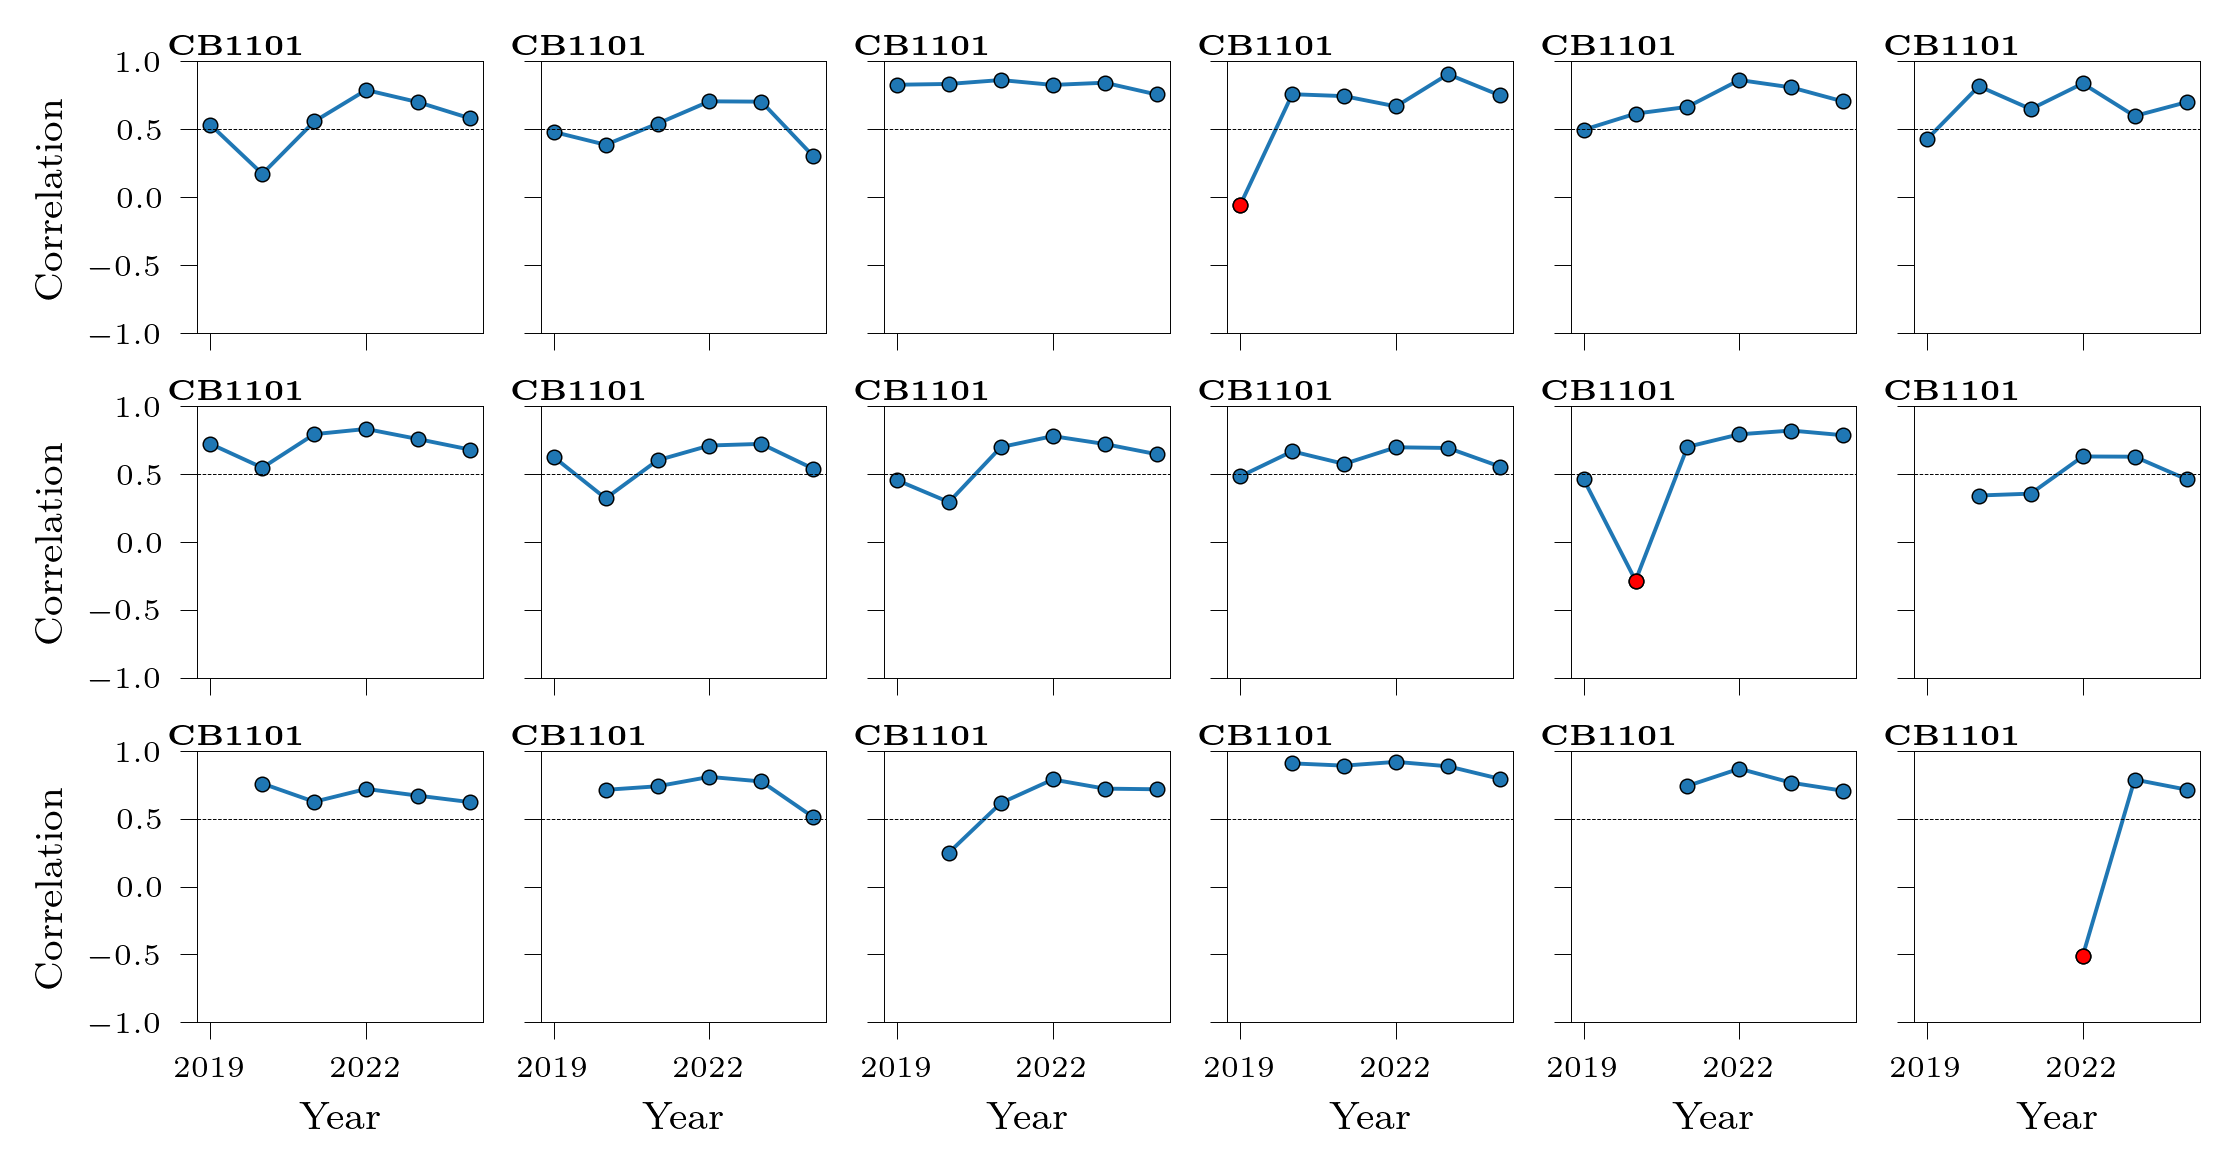

In [ ]:
correlation_coefficients_per_year = {}
counter_years_to_exclude = {}
for idx,device_name in enumerate(bike_counters_ids):
    device_combined = merged_datasets_complete[device_name]

    correlations_yearly = {}
    
    for year in [2019,2020,2021,2022,2023,2024]:
        device_combined_year = device_combined.loc[device_combined['year'] == year]

        corr_year = device_combined_year['counter_trips'].corr(device_combined_year['strava_trips'])     
        correlations_yearly[year]  = corr_year
        if corr_year <=0:
            if device_name not in counter_years_to_exclude:
                counter_years_to_exclude[device_name] = []
            counter_years_to_exclude[device_name].append(year)
    correlation_coefficients_per_year[device_name] = correlations_yearly

with open(f"{DATA_PATH}/bike_counters/counter_years_to_exclude.pkl", "wb") as f:
    pickle.dump(counter_years_to_exclude, f)

# Create a DataFrame where each row represents a counter and each column a year
df_corr = pd.DataFrame(correlation_coefficients_per_year).T

# Ensure years (columns) are in sorted order
df_corr = df_corr[sorted(df_corr.columns)]

num_counters = df_corr.shape[0]
num_cols = 6
num_rows = math.ceil(num_counters / num_cols)

fig_yearlycorrelation, ax_yearlycorrelation = plt.subplots(num_rows, num_cols, 
                                                           figsize=(cm_to_inches(FULL_PAGE_WIDTH_CM), num_rows * cm_to_inches(FULL_PAGE_LENGTH_CM)/9), dpi=350,sharex=True,sharey=True,constrained_layout = True)

for i, device in enumerate(df_corr.index):
    ax = ax_yearlycorrelation[i // num_cols, i % num_cols] if num_rows > 1 else ax_yearlycorrelation[i]
    # Plot the correlation coefficients for each year using markers and a line
    ax.plot(df_corr.columns, df_corr.loc[device].values, marker='o', linestyle='-',markersize=3,linewidth = 0.8,markeredgecolor='black',markeredgewidth=0.3)

    ax.plot(df_corr.columns[np.where(df_corr.loc[device].values < 0)], df_corr.loc[device].values[np.where(df_corr.loc[device].values < 0)], marker='o', linestyle='-',markersize=3,linewidth = 0.8,color = 'red',markeredgecolor='black',markeredgewidth=0.3)
    ax.text(-0.1, 1.10,
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,s = r"$\mathbf{"+device_name+"}$",fontsize = 6)

        
    if i // num_cols == num_rows - 1:
        ax.set_xlabel("Year", fontsize=label_dict['fontsize'])
    if i % num_cols == 0:
        ax.set_ylabel("Correlation", fontsize=label_dict['fontsize'])
    ax.set_ylim(-1, 1)
    ax.set_xticks([2019,2022])

    ax.tick_params(axis='both',labelsize=tick_dict['fontsize'],width =0.2)
    set_spines_width(ax,width = 0.2)

for ax in ax_yearlycorrelation.flat:
        ax.axhline(y=0.5, color='black', linestyle='--',linewidth = 0.2)

fig_yearlycorrelation.savefig(f"{SAVE_PATH}/figures/yearly_correlation_per_counter.pdf")